# Challenge: model comparison
You now know two kinds of regression and two kinds of classifier. So let's use that to compare models!

Comparing models is something data scientists do all the time. There's very rarely just one model that would be possible to run for a given situation, so learning to choose the best one is very important.

Here let's work on regression. Find a data set and build a KNN Regression and an OLS regression. Compare the two. How similar are they? Do they miss in different ways?

Create a Jupyter notebook with your models. At the end in a markdown cell write a few paragraphs to describe the models' behaviors and why you favor one model or the other. Try to determine whether there is a situation where you would change your mind, or whether one is unambiguously better than the other. Lastly, try to note what it is about the data that causes the better model to outperform the weaker model. Submit a link to your notebook below.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats.mstats import winsorize
from sklearn import neighbors
from sklearn.model_selection import (cross_val_score, train_test_split)
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse

sns.set_style('dark')
plt.style.use('dark_background')

In [2]:
# Like any good millennial, I chose a data set is historical Avocado pricing from Haas Avocados 2015 - 2018
data = pd.read_csv('https://raw.githubusercontent.com/dancassin/DATA/master/avocado.csv', index_col=0,
                  parse_dates=['Date'])

In [3]:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18249 entries, 0 to 11
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          18249 non-null  datetime64[ns]
 1   AveragePrice  18249 non-null  float64       
 2   Total Volume  18249 non-null  float64       
 3   4046          18249 non-null  float64       
 4   4225          18249 non-null  float64       
 5   4770          18249 non-null  float64       
 6   Total Bags    18249 non-null  float64       
 7   Small Bags    18249 non-null  float64       
 8   Large Bags    18249 non-null  float64       
 9   XLarge Bags   18249 non-null  float64       
 10  type          18249 non-null  object        
 11  year          18249 non-null  int64         
 12  region        18249 non-null  object        
dtypes: datetime64[ns](1), float64(9), int64(1), object(2)
memory usage: 1.9+ MB


,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


In [4]:
# We will be log transforming the Total Bags, so I'm dropping the 15 rows where 0 Total Bags are reported
# to avoid log of 0 issues
data = data[data['Total Bags']>0]

In [5]:
# No nulls to deal with
# Removing the columns that are types of avocados and the subsets of the columns I am interested in
data.drop(['4046', '4225', '4770', 'Small Bags', 'Large Bags', 'XLarge Bags', 'year'], axis=1, inplace=True)

In [6]:
# May potentially factor in organic in pricing
data = pd.concat([data, pd.get_dummies(data['type'], prefix='type', drop_first=True)], axis=1)

In [7]:
data.head()

,Date,AveragePrice,Total Volume,Total Bags,type,region,type_organic
0,2015-12-27,1.33,64236.62,8696.87,conventional,Albany,0
1,2015-12-20,1.35,54876.98,9505.56,conventional,Albany,0
2,2015-12-13,0.93,118220.22,8145.35,conventional,Albany,0
3,2015-12-06,1.08,78992.15,5811.16,conventional,Albany,0
4,2015-11-29,1.28,51039.60,6183.95,conventional,Albany,0


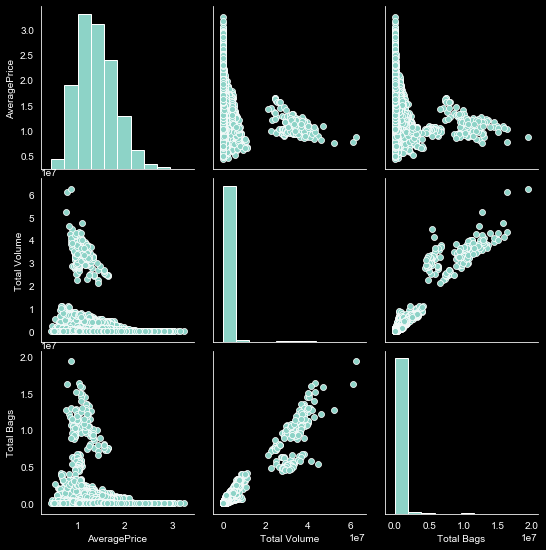

In [8]:
sns.pairplot(data[['AveragePrice', 'Total Volume', 'Total Bags']]);
# Regarding the histograms, it looks like total volume and total bags should be log transformed

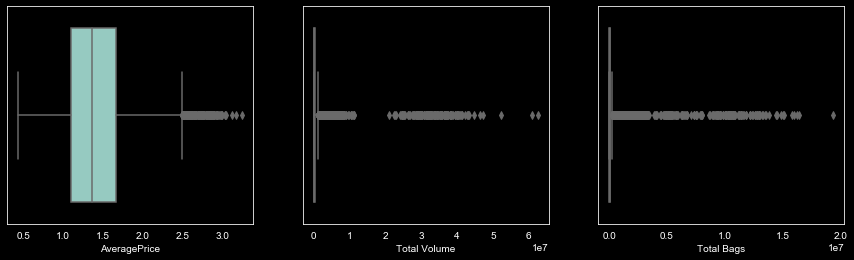

In [9]:
plt.figure(figsize=(15,4))

plt.subplot(1,3,1)
sns.boxplot(data['AveragePrice'])
plt.subplot(1,3,2)
sns.boxplot(data['Total Volume'])
plt.subplot(1,3,3)
sns.boxplot(data['Total Bags']);

In [10]:
data['winz_avg_p'] = winsorize(data['AveragePrice'], (0,.02))
data['log_vol'] = np.log(data['Total Volume'])
data['winz_log_bags'] = winsorize(np.log(data['Total Bags']),(0.005,0.005))
# 

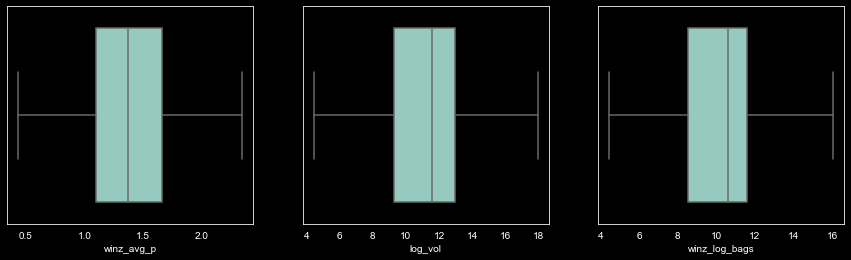

In [11]:
plt.figure(figsize=(15,4))

plt.subplot(1,3,1)
sns.boxplot(data['winz_avg_p'])
plt.subplot(1,3,2)
sns.boxplot(data['log_vol'])
plt.subplot(1,3,3)
sns.boxplot(data['winz_log_bags']);

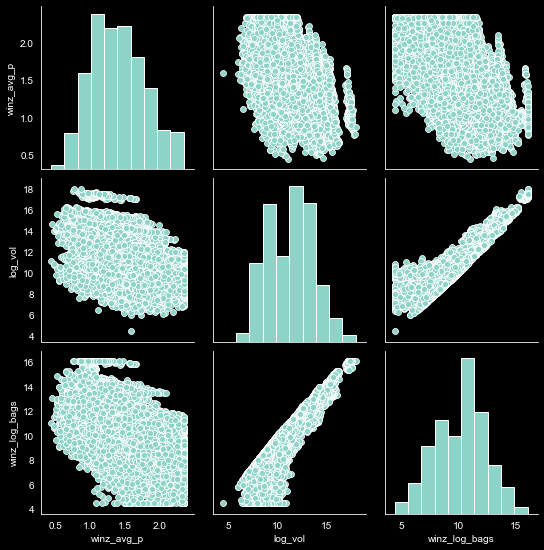

In [12]:
# Let's run the pairplot again
sns.pairplot(data[['winz_avg_p', 'log_vol', 'winz_log_bags']]);
# Here we can see volume and bags are much more normal in distribution
# and we can see there's a a negative relationship between average price and volume
# so people are buying more as the price goes down, which makes economic sense

In [13]:
data.head()

,Date,AveragePrice,Total Volume,Total Bags,type,region,type_organic,winz_avg_p,log_vol,winz_log_bags
0,2015-12-27,1.33,64236.62,8696.87,conventional,Albany,0,1.33,11.070329,9.070718
1,2015-12-20,1.35,54876.98,9505.56,conventional,Albany,0,1.35,10.912849,9.159632
2,2015-12-13,0.93,118220.22,8145.35,conventional,Albany,0,0.93,11.680304,9.005202
3,2015-12-06,1.08,78992.15,5811.16,conventional,Albany,0,1.08,11.277104,8.667535
4,2015-11-29,1.28,51039.60,6183.95,conventional,Albany,0,1.28,10.840357,8.729713


In [14]:
# Creating model variables and target
X = data[['winz_avg_p', 'winz_log_bags', 'type_organic']]
Y = data['log_vol']

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=.2)

In [15]:
# Build our model to predict the total amount of bags of avocados sold
# After some testing non-weighted seems to perform best
knn = neighbors.KNeighborsRegressor(n_neighbors=50)
results = knn.fit(X_train, Y_train)

Y_preds = results.predict(X_test)


score = cross_val_score(knn, X_train, Y_train, cv=5)
print("Unweighted Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))


Unweighted Accuracy: 0.94 (+/- 0.00)


In [16]:
score = cross_val_score(knn, X_test, Y_test, cv=5)
print("Unweighted Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

Unweighted Accuracy: 0.94 (+/- 0.01)


('Mean absolute error of the prediction is: 0.4',
 'Mean squared error of the prediction is: 0.29',
 'Root mean squared error of the prediction is: 1.0',
 'Mean absolute percentage error of the prediction is: 3.85%')

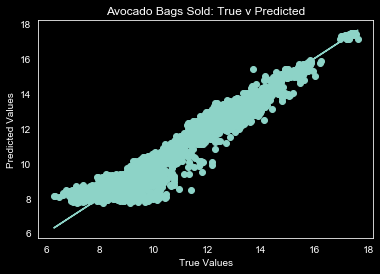

In [17]:
Y_preds = results.predict(X_test)

plt.scatter(Y_test, Y_preds)
plt.plot(Y_test, Y_test)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Avocado Bags Sold: True v Predicted')

def error_stats(y_test, ypreds):
    MAE = f"Mean absolute error of the prediction is: {round(mean_absolute_error(Y_test, Y_preds), 2)}"
    MSE = f"Mean squared error of the prediction is: {round(mse(Y_test, Y_preds),2)}"
    RMSE = f"Root mean squared error of the prediction is: {round(rmse(Y_test, Y_preds))}"
    MAPE = f"Mean absolute percentage error of the prediction is: {round(np.mean(np.abs((Y_test - Y_preds) / Y_test) * 100),2)}%"
    return MAE, MSE, RMSE, MAPE

error_stats(Y_test, Y_preds)

In [18]:
# Creating 
lrm = LinearRegression()
results = lrm.fit(X_train,Y_train)

score = cross_val_score(lrm, X_train, Y_train, cv=5)
print("Unweighted Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

Unweighted Accuracy: 0.92 (+/- 0.00)


In [19]:
results = lrm.fit(X_test,Y_test)

score = cross_val_score(lrm, X_test, Y_test, cv=5)
print("Unweighted Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

Unweighted Accuracy: 0.92 (+/- 0.02)


('Mean absolute error of the prediction is: 0.49',
 'Mean squared error of the prediction is: 0.44',
 'Root mean squared error of the prediction is: 1.0',
 'Mean absolute percentage error of the prediction is: 4.74%')

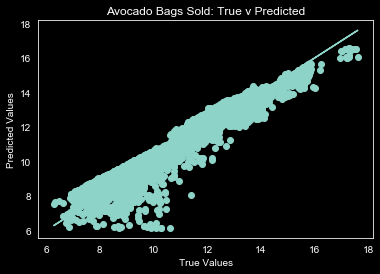

In [20]:
Y_preds = results.predict(X_test)

plt.scatter(Y_test, Y_preds)
plt.plot(Y_test, Y_test)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Avocado Bags Sold: True v Predicted')

def error_stats(y_test, ypreds):
    MAE = f"Mean absolute error of the prediction is: {round(mean_absolute_error(Y_test, Y_preds), 2)}"
    MSE = f"Mean squared error of the prediction is: {round(mse(Y_test, Y_preds),2)}"
    RMSE = f"Root mean squared error of the prediction is: {round(rmse(Y_test, Y_preds))}"
    MAPE = f"Mean absolute percentage error of the prediction is: {round(np.mean(np.abs((Y_test - Y_preds) / Y_test) * 100),2)}%"
    return MAE, MSE, RMSE, MAPE

error_stats(Y_test, Y_preds)

While I initally thought this data set would be perfect for linear regression, the KNN model appears to work better on this data set than the linear regression model in all stats. I believe the amount of data points and their close proximity is helpful for the KNN model. Also it is likely there are underlying subgroups of pricing or bags that make KNN more effective.